# Setup

## Colab setup

Run the following cells in order (by pressing `Shift-Enter` or clicking on the "play" button at the top-left of a cell when mousing over it). When a warning pops up, choose "Run anyway".

In [ ]:
!rm -r sample_data
!git clone https://github.com/SimoneBarbaro/data_science_lab_project.git

In [ ]:
import os
os.chdir("./data_science_lab_project/data")
!wget -O TWOSIDES_medDRA.csv.gz https://polybox.ethz.ch/index.php/s/Uemf21AIiZ7ooNi/download
!wget -O rare_targets.csv https://polybox.ethz.ch/index.php/s/iP10qmPV6mfLhQa/download
os.chdir("..")

_**Simplifying update in the works: only results will need to be uploaded. Stay tuned for the update.**_

While waiting for the downloads above to complete, open the file browser on the left by clicking on the folder icon.

**Upload the results archive `results_2020_12_06.zip` ([Polybox link](https://polybox.ethz.ch/index.php/f/2172234367)) to the `data_science_lab_project` folder** by hovering over the folder and choosing "Upload" from the three-dots menu that appears on the right or by dragging and dropping the zip archive from your file browser onto the `data_science_lab_project` folder. `results_2020_12_06.zip` should then be within the `data_science_lab_project` folder below the `data` and `src` folders, which you can check by expanding the folder contents by clicking on the triangle on the left of the folder name. Note that this upload can take about 20 minutes. You can check the progress of the upload in the bottom left corner.

**Upload the paired SPiDER and TIGER data into the `data` folder** (within the `data_science_lab_project` folder) using the three-dots menu of the `data` folder or by dragging and dropping the files from your file browser onto the `data` folder.
- `matrix_spider_filtered_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2172246742))
- `matrix_spider_filtered_full_names.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2172246700))
- `matrix_tiger_filtered_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2173238290))
- `matrix_tiger_filtered_full_names.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2173237759))

When finished, expand the `data` folder and check that the files show up as in the screenshot below:
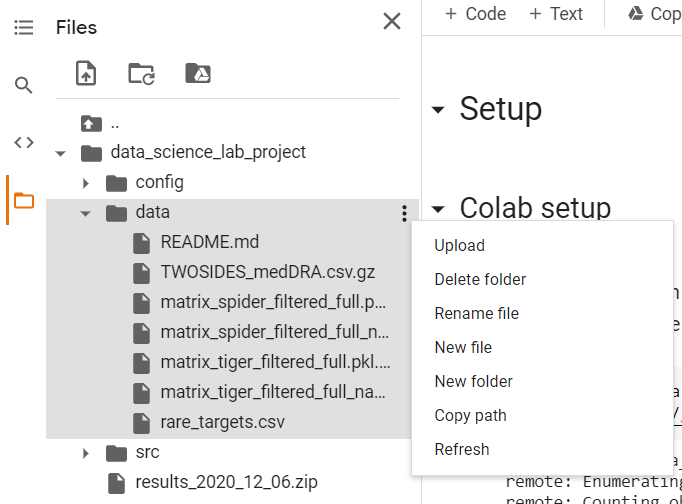

In [ ]:
!unzip results_*.zip

In [ ]:
!pip install -r src/requirements.txt
os.chdir("src")

Read the available results from the file system: 

In [1]:
import os, json, re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
cwd = os.getcwd()
results_directory = "../results"
results_directory = os.path.join(cwd, results_directory)
results_table = []
for f in os.listdir(results_directory):
    path = os.path.join(results_directory, f)
    if os.path.isdir(path):
        info_data = os.path.join(path, "results_info.json")
        if os.path.exists(info_data):
            with open(info_data) as info_f:
                info = json.load(info_f)
            results_table.append({"folder": f,
                                  "dataset": info["dataset"],
                                  "method": re.search("_(.*?)[0-9]", f).group(1),
                                  "clusters": re.search("([0-9]+)", f).group(1),
                                  "normalization": "norm" if re.search("norm", f) else "",
                                  "aggl_ave": "ave" if re.search("ave", f) else "",
                                  "silhouette": info["silhouette_score"]})
        else:
            results_table.append({"folder": f})
results_table = pd.DataFrame(results_table)

def full(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_seq_items', None, 'display.max_colwidth', None):
        display(df)

Running the following cell should now list the runs that can be analyzed: each first specifies the dataset, then the clustering method, followed by the number of clusters and other relevant parameters.

The clustering methods are:
- `aggl`: [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
    - `ave` in agglomerative clustering refers to the parameter `linkage='average'` (as opposed to the default `linkage='ward'`)
- `kmeans`: [K-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- `gmm`: [Gaussian mixture model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

`norm` refers to [normalization of columns to a standard normal distribution](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) prior to clustering.

[Silhouette scores](https://en.wikipedia.org/wiki/Silhouette_(clustering)) are also reported: a higher score (maximum 1) means the clusters are more coherent.

In [2]:
sorting_column = "silhouette"
sort_increasing = False

full(results_table.sort_values(sorting_column, ascending=sort_increasing))
# Note the use of the "full" function above: in case a table is not displayed in full
# (rows, columns or text hidden), you may wrap it into "full(...)" to show it in full.

ValueError: Value must have type '<class 'int'>'

## Choose one of the clustering methods from the "folder" column above

In [3]:
name_analysis = 'spider_aggl5avenorm'

In [4]:
# The following sets up filepath variables for use later in the notebook
result_path = os.path.join(results_directory, name_analysis)
analysis_path = os.path.join(result_path, "analysis")

# Clusters

Show the beginning of the clustering results file to check it was read correctly:

In [5]:
pth = os.path.join(result_path, 'results.csv')
clustering_results = pd.read_csv(pth)
display(clustering_results.head())
print("Number of drug pairs: {}\nNumber of clusters: {} (from {} to {})".format(clustering_results.shape[0], clustering_results["cluster"].drop_duplicates().count(), clustering_results["cluster"].min(), clustering_results["cluster"].max()))

,name1,name2,cluster
0,6-aminocaproic acid,acetaminophen,0
1,6-aminocaproic acid,albuterol,0
2,6-aminocaproic acid,aspirin,0
3,6-aminocaproic acid,bumetanide,0
4,6-aminocaproic acid,cefazolin,0


Number of drug pairs: 51686
Number of clusters: 5 (from 0 to 4)


Query for a specific drug pair provide names of both drugs in cell below:

In [6]:
name1 = 'tamoxifen'
name2 = 'bupropion'
clustering_results[(clustering_results['name1'] == name1) & (clustering_results['name2'] == name2)]

,name1,name2,cluster
27564,tamoxifen,bupropion,0


# Side effects analysis

## Choose a level of side effects

There are five levels to the MedDRA hierarchy, of which four are available here. `System Organ Classes (SOC)` are the highest level terms based on location, etiology, or purpose. `High Level Group Terms (hlgt)` which are the next highest level terms are groups of `High Level Terms (hlt)` grouped together by anatomy, pathology, physiology, etiology and function. Likewise, `High Level Terms (hlt)`s themselves are groups of `Preferred Terms (pt)`, the most specific terms, grouped together by the same criteria.

In the cell below, choose the analysis level of Meddra terms to look at for the analysis.

In [7]:
analysis_level = 'soc'

In [8]:
pth = os.path.join(analysis_path, 'scores_' + analysis_level + '_term.csv')
sideeffect_results = pd.read_csv(pth)
sideeffect_results

,cluster,soc_term,perc,tfidf_score,rank
0,0,Blood and lymphatic system disorders,0.023382,0.097349,15.0
1,0,Cardiac disorders,0.054367,0.226354,10.0
2,0,"Congenital, familial and genetic disorders",0.001605,0.007902,26.0
3,0,Ear and labyrinth disorders,0.006005,0.025000,24.0
4,0,Endocrine disorders,0.013389,0.055743,20.0
5,0,Eye disorders,0.017896,0.074510,18.0
6,0,Gastrointestinal disorders,0.075936,0.316157,2.0
7,0,General disorders and administration site cond...,0.073715,0.306910,3.0
8,0,Hepatobiliary disorders,0.016319,0.067943,19.0
9,0,Immune system disorders,0.018935,0.078834,17.0


Show the top `N` side effects per group:

In [9]:
N = 4

full(sideeffect_results.sort_values(["cluster","rank"]).groupby("cluster").head(N).set_index(["cluster", "{}_term".format(analysis_level)]))

ValueError: Value must have type '<class 'int'>'

## Clusters numbers

Show cluster labels and count them:

In [10]:
sideeffect_results["cluster"].drop_duplicates().values

array([0, 1, 2, 3, 4], dtype=int64)

In [11]:
num_clusters = sideeffect_results["cluster"].drop_duplicates().count()
num_clusters

5

## Choose a specific cluster to inspect

Below, one can choose which specific cluster to look at and analyze the significant side effects by changing the `cluster_no` variable.

In [12]:
cluster_no = 0

In [14]:
sideeffect_results[sideeffect_results['cluster'] == cluster_no].sort_values("rank")

,cluster,soc_term,perc,tfidf_score,rank
16,0,Nervous system disorders,0.098432,0.409818,1.0
6,0,Gastrointestinal disorders,0.075936,0.316157,2.0
7,0,General disorders and administration site cond...,0.073715,0.306910,3.0
25,0,Vascular disorders,0.071743,0.298698,4.0
18,0,Psychiatric disorders,0.063654,0.265019,5.0
21,0,"Respiratory, thoracic and mediastinal disorders",0.063459,0.264211,6.0
12,0,Investigations,0.062298,0.259376,7.0
14,0,Musculoskeletal and connective tissue disorders,0.061136,0.254537,8.0
11,0,"Injury, poisoning and procedural complications",0.058636,0.244126,9.0
1,0,Cardiac disorders,0.054367,0.226354,10.0


# Significance Analysis

The significance analysis shows which side effects are shown to be significant in each cluster using the [Grubbs test](https://en.wikipedia.org/wiki/Grubbs%27s_test#One-sided_case) at a significance level of 0.005. Below, choose a level of MedDRA hierarchy to observe the significant side effects predicted in each cluster. <!-- The `alpha` value determines the statistical significance level for which effects are significant. Currently only results for `alpha = 0.005` are computed. // alpha = 0.005  # Currently only 0.005 is available, do not change -->

## Choose a level of side effects

In [15]:
analysis_level = 'soc'

In [16]:
pth = os.path.join(analysis_path, 'significant_' + analysis_level + '_ranks_' + str(0.005) + '.csv')
statistical_results = pd.read_csv(pth)
full(statistical_results)

ValueError: Value must have type '<class 'int'>'

Look at a given side effect term for all clusters:

In [17]:
term = "Pregnancy, puerperium and perinatal conditions"
sideeffect_results[(sideeffect_results.iloc[:,1] == term)].sort_values("tfidf_score", ascending=False)

,cluster,soc_term,perc,tfidf_score,rank
119,4,"Pregnancy, puerperium and perinatal conditions",0.008666,0.041565,20.0
69,2,"Pregnancy, puerperium and perinatal conditions",0.005816,0.029072,23.0
43,1,"Pregnancy, puerperium and perinatal conditions",0.003071,0.015167,25.0
17,0,"Pregnancy, puerperium and perinatal conditions",0.002649,0.013041,25.0


Look at the significant results summary. Each row shows a drug pair, its cluster and the top `soc`, top 3 `hlgt`, top 3 `hlt` and top 3 `pt` side effects for that cluster. `NaN` means the cluster did not have a significant side effect at a given level.

In [13]:
pth = os.path.join(analysis_path, 'significant_summary_ranks_' + str(0.005) + '.csv')
summary_results = pd.read_csv(pth)
summary_results

Query for specific drugs

In [14]:
name1 = 'tamoxifen'
name2 = 'bupropion'
summary_results[(summary_results['name1'] == name1) & (summary_results['name2'] == name2)]

,name1,name2,cluster,soc1,hlgt1,hlgt2,hlgt3,hlt1,hlt2,hlt3,pt1,pt2,pt3
27092,tamoxifen,bupropion,0,Renal and urinary disorders,Respiratory and mediastinal neoplasms malignan...,Bone and joint therapeutic procedures,"Sexual dysfunctions, disturbances and gender i...",Gastrointestinal haemorrhages,Angioedemas,Non-site specific necrosis and vascular insuff...,Urinary incontinence,Incontinence,Anaphylactic reaction


# Target distribution for significant clusters

This block will run the Interactive Analysis for identifying the strongest targets in each cluster.

In [15]:
from experiment.interactive_analysis import InteractiveAnalyzer

This may take some time as it needs to load TWOSIDES for further analysis.

In [16]:
analyzer = InteractiveAnalyzer(result_path)

#### Choose the level, the number of clusters to consider and the number of targets per cluster to show

In [27]:
analysis_level = 'hlgt'
targets_per_cluster = 15
cluster_number = 0

In [28]:
significant_clusters, important_targets = analyzer.get_important_data(analysis_level, cluster_number, targets_per_cluster)
significant_clusters

,cluster,hlgt_term,perc,tfidf_score,rank,grubbs,counts


List clusters with their side effects in increasing order of importance along with top targets in the cluster:

In [ ]:
full(analyzer.make_more_complete_summary(significant_clusters, important_targets))

From the table above, only show the top `N` side effects of each cluster:

In [ ]:
N = 3
full(analyzer.make_more_complete_summary(significant_clusters, important_targets)
                 .groupby("cluster").head(N).set_index(["cluster", "{}_term".format(analysis_level)])
                 .drop(columns=["perc","tfidf_score","rank","grubbs","counts","Rare"]))

Return any clusters where an important target is from the pre-defined list of rare targets:

In [ ]:
analyzer.get_rare_important_targets(cluster_number, targets_per_cluster)

#### Choose a specific cluster to inspect from the column "cluster" above
as well as a threshold value (between 0 and 2 for SPiDER) representing sufficient probability for a drug pair to interact with a target.

In [ ]:
cluster_no = 0
threshold = 0.5

Descriptive statistics of the distribution of scores for important target of the chosen cluster:

In [ ]:
important_targets = analyzer.get_important_targets(cluster_no, targets_per_cluster)
desc = important_targets.describe()
frac = (important_targets > threshold).sum()/(important_targets.count())
frac = frac.rename("Fraction above Threshold")
desc.append(frac)

#### Choose a target to visualize from the columns above

In [ ]:
target = 'Serine Threonine Kinase'

Histogram of the distribution of the scores of the given target within the chosen cluster:

In [ ]:
important_targets[target].plot.hist(xlim=([0,2] if "spider" in name_analysis else None))
plt.axvline(threshold, color='k', linewidth=2)
plt.text(threshold-0.055, plt.axis()[3]*0.2, 'threshold', rotation=90)